# Coursework 1: Chest X-ray (100 marks)

In this coursework, you will be working with the Kaggle [Chest X-Ray Images (Pneumonia)](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia/data) dataset. You will analyze the dataset, and train deep learning models to classify whether an x-ray exhibits pneumonia.


The coursework is structured as follows:

1. Data Analysis: 5 marks
2. Data Preparation: 5 marks
3. Training a Baseline: 30 marks
4. Improving the Baseline: 50 marks
5. Evaluating on the Test Set: 10 marks

In each question will require you tocode up a solution, and to briefly explain and discuss your choices and results.

__IMPORTANT__
* Pretrained models are __NOT__ allowed. You will recieve __0__ marks for any use of pretrained models.
* The use of LLM/AI support including writing and coding aligns to the UCL guidelines. This includes the use of code prompts and Gemini in Google Collab

Here are some additional tips:
- We recommend using weights and biases to log your training runs. This will allow you to easily compare previous runs if needed.
- Ensure your results are reproducable - we may rerun your notebook to check for this. Points will be lost if results are not reproducable.
- We recommend factorizing your code in places where you will be repeatedly using the same functionaility. For example, if you are training multiple models, consider using a common training loop function.
- Your code and results and discussions should be concise, well-presented, and easy to read. Each question has a certain portion of marks going towards this.
- Ensure you correctly use the train, validation, and test set throughout. You should only ever use the test set once - for the final evaluation.
- Consider saving your models so you can reload previous models for the final evaluation
- Ensure it is clear to the reader what any plots / figures are presenting. I.e., label axes, include titles, ensure it is clear what experiment it is from (what model / design choices, etc.)
- Google Collab restricts the amount of GPU time available. Consider debugging code, using a subset of data, on CPU compute

In [ ]:
!pip install kaggle
!pip install wandb

If you get the following error when running the import cell below this description:


```
OSError: Could not find kaggle.json. Make sure it's located in /root/.config/kaggle. Or use the environment method. See setup instructions at https://github.com/Kaggle/kaggle-api/
```
You will need to create a kaggle account, and navigate to https://www.kaggle.com/me/account. Navigate to "API" and create a new token. This will automatically download a json file called "kaggle.json".

Run the following code, replacing the "INSERT JSON HERE TEXT" with the contents of the json that you downloaded.

```
!mkdir /root/.config/kaggle
!touch /root/.config/kaggle/kaggle.json

api_token = INSERT JSON HERE TEXT

import json

with open('/root/.config/kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 /root/.config/kaggle/kaggle.json
```

INSERT JSON HERE TEXT should be something of the form:
```
{"username":"XXX","key":"XXX"}
```

In [1]:
import os
import random
import shutil
import kaggle
from kaggle.api.kaggle_api_extended import KaggleApi
import matplotlib.pyplot as plt
import numpy as np

import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from collections import Counter

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import models, transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import wandb

In [2]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Load and Re-split the Raw Data

The original data is poorly split, so we will resplit it here. Do NOT edit this code.

In [3]:
# Hyperparameters
TRAIN_SPLIT = 0.8
VAL_SPLIT = 0.1
TEST_SPLIT = 0.1  # This is implicitly defined as 1 - (TRAIN_SPLIT + VAL_SPLIT)

In [4]:
# Set up the Kaggle API
api = KaggleApi()
api.authenticate()

# Specify the dataset
dataset = "paultimothymooney/chest-xray-pneumonia"

# Specify the download path
download_path = "chest_xray_dataset"

# Check if the dataset is already downloaded
if os.path.exists(os.path.join(download_path, "chest_xray")):
    print(f"Dataset already exists at {download_path}. Skipping download.")
else:
    # Create the download directory if it doesn't exist
    os.makedirs(download_path, exist_ok=True)

    # Download the dataset
    print(f"Downloading {dataset} to {download_path}")
    api.dataset_download_files(dataset, path=download_path, unzip=True)
    print("Download complete!")

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
Download complete!


In [5]:
# Re-split data
dataset_path = os.path.join(download_path, "chest_xray")
new_dataset_path = "chest_xray_dataset_new_split"

if not os.path.exists(new_dataset_path):
    # Create new directory structure
    for split in ['train', 'val', 'test']:
        for cls in ['NORMAL', 'PNEUMONIA']:
            os.makedirs(os.path.join(new_dataset_path, split, cls), exist_ok=True)

    for cls in ['NORMAL', 'PNEUMONIA']:
        all_files = []
        for split in ['train', 'val', 'test']:
            source_folder = os.path.join(dataset_path, split, cls)
            files = os.listdir(source_folder)
            all_files.extend([(file, source_folder) for file in files])

        # Sort files to ensure consistent order before shuffling
        all_files.sort()

        # Create a new Random object with the seed
        rng = random.Random(42)

        # Use the shuffle method of the Random object
        rng.shuffle(all_files)

        total_files = len(all_files)
        train_end = int(total_files * TRAIN_SPLIT)
        val_end = int(total_files * (TRAIN_SPLIT + VAL_SPLIT))

        train_files = all_files[:train_end]
        val_files = all_files[train_end:val_end]
        test_files = all_files[val_end:]

        for split, file_list in [('train', train_files), ('val', val_files), ('test', test_files)]:
            for file, source_folder in file_list:
                source = os.path.join(source_folder, file)
                dest = os.path.join(new_dataset_path, split, cls, file)
                shutil.copy(source, dest)

    print(f"Data re-split complete. New dataset location: {new_dataset_path}")
else:
    print(f"Re-split dataset already exists at {new_dataset_path}")

Data re-split complete. New dataset location: chest_xray_dataset_new_split


# Question 1: Data Analysis (5 marks)

Perform some basic analysis of the statistics of the dataset.

Try to spot anything that may impact how you will design your deep learning classifier and training.

We'd expect to see:
* Analysis of labels (target variable);
* Analysis of input features;

If you do spot anything, briefly explain **how you think it may impact training**.


In [6]:
# Collect dataset statistics
splits = ['train', 'val', 'test']
classes = ['NORMAL', 'PNEUMONIA']

stats = {split: {cls: 0 for cls in ['NORMAL', 'PNEUMONIA']} for split in ['train', 'val', 'test']}
for split in splits:
    for cls in classes:
        path = os.path.join(new_dataset_path, split, cls)
        stats[split][cls] = len(os.listdir(path))

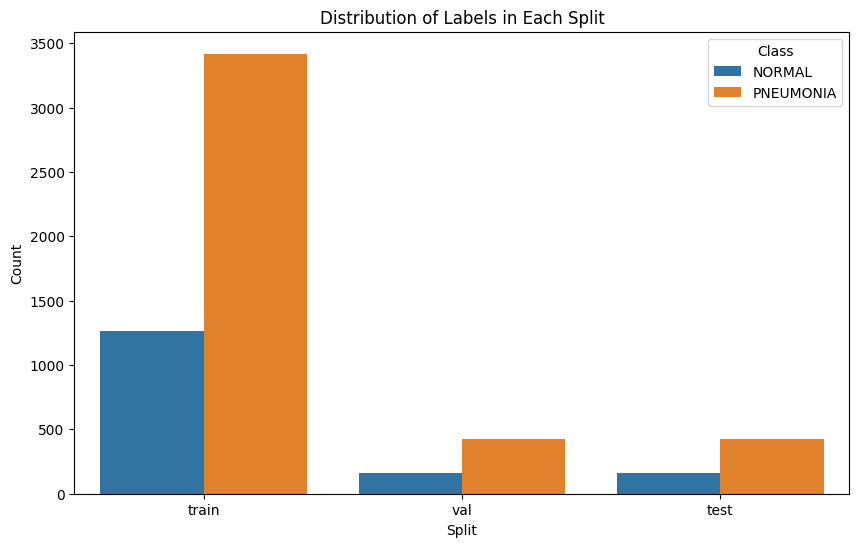

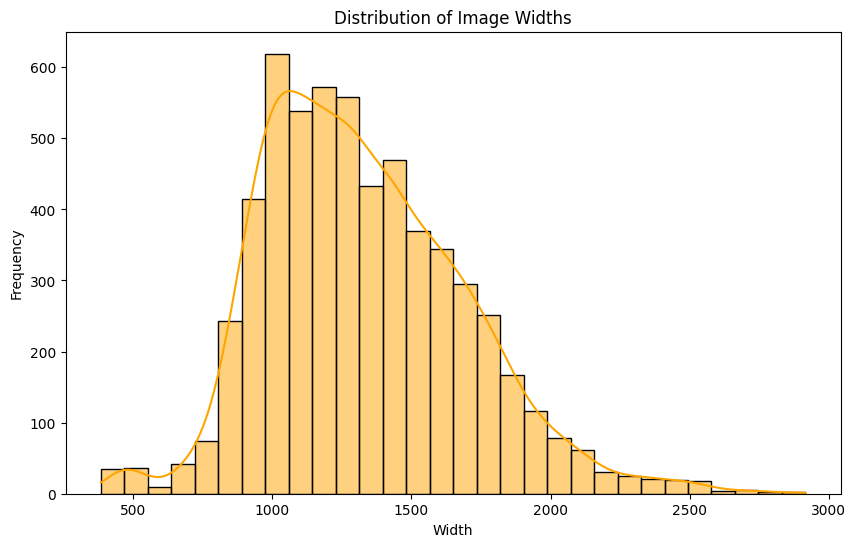

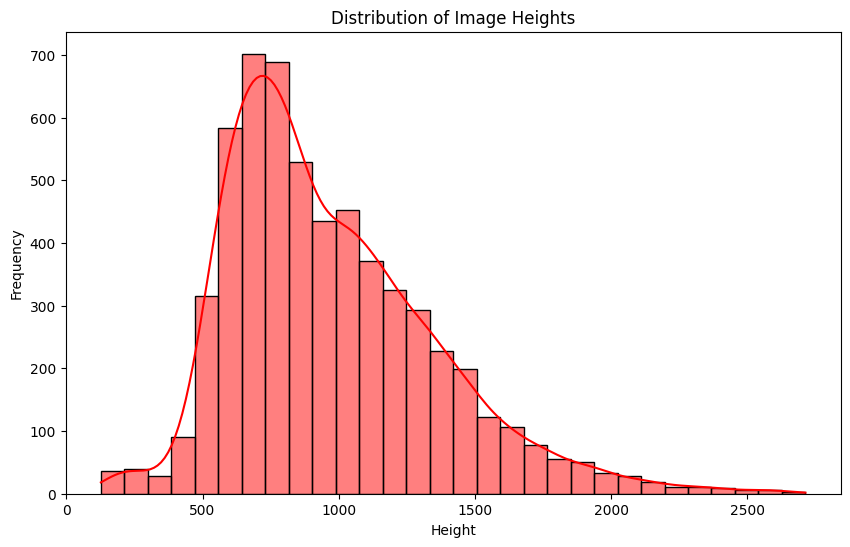

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
import os

# Convert stats to a DataFrame for easier visualization
stats_df = pd.DataFrame(stats).reset_index().melt(id_vars='index')
stats_df.columns = ['Class', 'Split', 'Count']

# Plot the distribution of labels
plt.figure(figsize=(10, 6))
sns.barplot(x='Split', y='Count', hue='Class', data=stats_df)
plt.title('Distribution of Labels in Each Split')
plt.show()

# Analyze input features (btw in this case is image dimensions)
image_dimensions = {'width': [], 'height': []}
for split in splits:
    for cls in classes:
        path = os.path.join(new_dataset_path, split, cls)
        for file in os.listdir(path):
            img = Image.open(os.path.join(path, file))
            width, height = img.size
            image_dimensions['width'].append(width)
            image_dimensions['height'].append(height)

# Convert image dimensions to a DataFrame BETTER VISUALIZATION
dimensions_df = pd.DataFrame(image_dimensions)

# Plot the distribution of image widths
plt.figure(figsize=(10, 6))
sns.histplot(dimensions_df['width'], kde=True, bins=30, color='orange')
plt.title('Distribution of Image Widths')
plt.xlabel('Width')
plt.ylabel('Frequency')
plt.show()

# Plot the distribution of image heights
plt.figure(figsize=(10, 6))
sns.histplot(dimensions_df['height'], kde=True, bins=30, color='red')
plt.title('Distribution of Image Heights')
plt.xlabel('Height')
plt.ylabel('Frequency')
plt.show()


**(a)**
The distribution of the classes ("NORMAL" and "PNEUMONIA") across the training, validation, and test sets. The class distribution seems highly imbalanced in all splits such that the "PNEUMONIA" class has significantly more images than the "NORMAL" class in all three datasets (train, validation, and test). While training, this will make the classifier biased towards predicting "PNEUMONIA" more frequently since it appears much more often in the dataset. And this could lead to poor performance when predicting the minority class ("NORMAL").

The distribution of image widths and heights shows that the images seem to vary in size, but the majority of the images have a width between 500-1500 pixels and a height between 500-2000 pixels. It would do am impact on training, since our model often requires fixed-size inputs. We would need to resize them to a uniform size before feeding them into our model, which, if you don't do that, would result in poor convergence, lower accuracy, and suboptimal performance for training. While resizing sometimes causes distortions which could affect the model's ability to learn useful pattern.

## Let's see the ratio of width and heights for each image!

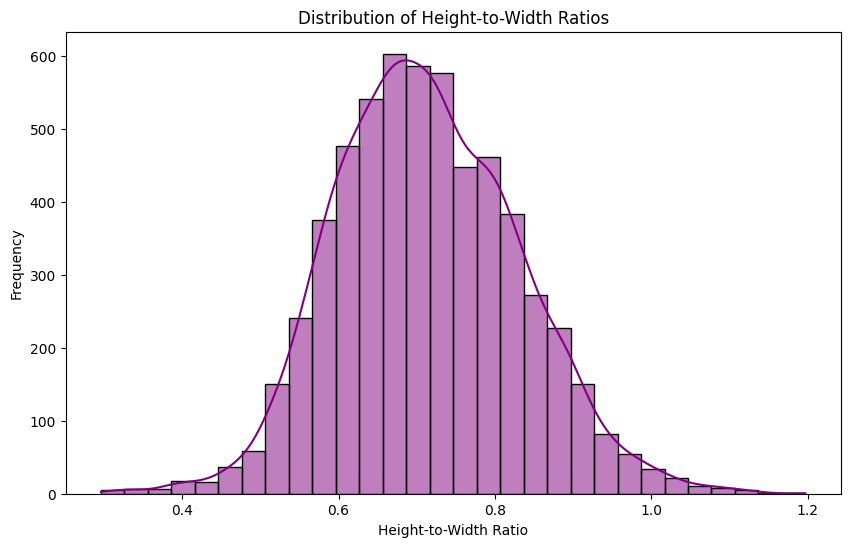

In [8]:
# Calculate the ratio of height to width
dimensions_df['ratio'] = dimensions_df['height'] / dimensions_df['width']

# Plot the distribution of the ratio of heights to widths
plt.figure(figsize=(10, 6))
sns.histplot(dimensions_df['ratio'], kde=True, bins=30, color='purple')
plt.title('Distribution of Height-to-Width Ratios')
plt.xlabel('Height-to-Width Ratio')
plt.ylabel('Frequency')
plt.show()

The distribution of ratio of height to width for each image shows that it follows a normal distribution which suggests that the images have a relatively consistent aspect ratio, which is good!

# Question 2: Data Preparation (5 marks)

Here, you should load the dataset into torch dataloaders, performing any preprocessing required in the process.

Within the ChestXrayDataset class, the root_dir parameter is a string defining the directory containing the "train", "val" and "test" folders.

In [9]:
dataset_path = "chest_xray_dataset_new_split"
batch_size = 32

In [10]:
class ChestXrayDataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None):
        self.root_dir = root_dir
        self.split = split
        self.transform = transform

        self.images = []
        self.labels = []
        self.load_dataset()

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]

        img = Image.open(img_path).convert('RGB')

        if self.transform:
            img = self.transform(img)

        return img, label
    
    def load_dataset(self):
        normal_path = os.path.join(self.root_dir, self.split, 'NORMAL')
        pneumonia_path = os.path.join(self.root_dir, self.split, 'PNEUMONIA')

        normal_files = [os.path.join(normal_path, file) for file in os.listdir(normal_path)]
        pneumonia_files = [os.path.join(pneumonia_path, file) for file in os.listdir(pneumonia_path)]

        self.images = normal_files + pneumonia_files
        self.labels = [0] * len(normal_files) + [1] * len(pneumonia_files)

In [11]:
from torchvision import transforms

# Define transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize to a consistent size
    transforms.RandomHorizontalFlip(),  # Random horizontal flip
    transforms.RandomRotation(10),  # Random rotation
    transforms.ToTensor(),  # Convert to tensor
])

In [14]:
# Create datasets
train_dataset = ChestXrayDataset(root_dir=dataset_path, split='train', transform=transform)
val_dataset = ChestXrayDataset(root_dir=dataset_path, split='val', transform=transform)
test_dataset = ChestXrayDataset(root_dir=dataset_path, split='test', transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Print dataset sizes
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

# Print batch shapes
for images, labels in train_loader:
    print(f"Batch images shape: {images.shape}")
    print(f"Batch labels shape: {labels.shape}")
    break

Train dataset size: 4684
Validation dataset size: 585
Test dataset size: 587
Batch images shape: torch.Size([32, 3, 256, 256])
Batch labels shape: torch.Size([32])


**(a)**

_Insert brief discussion of any design choices you made here_

# Question 3: Training a Baseline (30 marks)

You will now establish an initial baseline model and training procedure. This should be as simple as possible, without using any elaborate design choices, whilst still obtaining reasonable performance (i.e., at least better than random chance). You will attempt to improve upon this baseline in later questions.

When answering this question, consider what makes a good baseline:
* Easily converges;
* Easy to implement;
* Established architectural components that have proved well suited to the data-type and problem.
* Obtains reasonable performance e.g, better than random guess

You will be required to explain your design choices, and to present and discuss you results.

The code below is a suggested structure to guide you. You are free to deviate from this __however, it must be obvious to the marker__:
* What the final proposed baseline model is (in terms of architecture);
* What the performance of the baseline model is and how the model has been trained;
* What your written justification and discussion is;



In [ ]:
num_epochs = 10
use_wandb = True  # Set to True if you want to use wandb
lr = 1e-3

In [ ]:
from torchsummary import summary 

class SimpleCNN(nn.Module):
    def __init__(self, input_size=256, num_classes=2):
        super().__init__()
        
        self.conv_relu_pool_stack = nn.Sequential(
            # Layer 1: Input channels = 1 (grayscale), Output channels = 16
            nn.Conv2d(1, 16, 3, 1, 1),
            nn.ReLU(),
            nn.AvgPool2d(2),  # Reduces size to 128x128

            # Layer 2: Input channels = 16, Output channels = 8
            nn.Conv2d(16, 8, 3, 1, 1),
            nn.ReLU(),
            nn.AvgPool2d(2)   # Reduces size to 64x64
        )

        # Calculate the size after convolution and pooling
        final_size = input_size // 4  # After two AvgPool2d(2) layers, the size is divided by 4
        self.flatten = nn.Flatten()

        # Fully connected layer
        self.out_layer = nn.Linear(final_size * final_size * 8, num_classes)

    def forward(self, x):
        x = self.conv_relu_pool_stack(x)
        x = self.flatten(x)
        x = self.out_layer(x)
        return x

# the input image size is 256x256, and we have 2 classes (binary classification)
input_size = 256
num_classes = 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate and move the model to the device (GPU)
model = SimpleCNN(input_size=input_size, num_classes=num_classes).to(device)

# Print a summary of the model to check the dimensions
summary(model, (1, 256, 256))


In [ ]:
# Define the model
class SimpleModel(nn.Module):

        ########################################################################
        #                              YOUR CODE HERE                          #
        ########################################################################



        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################


In [ ]:
def calculate_class_accuracy(outputs, labels):
        ########################################################################
        #                              YOUR CODE HERE                          #
        ########################################################################



        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=30, device='cuda', use_wandb=False):

        ########################################################################
        #                              YOUR CODE HERE                          #
        ########################################################################

# Feel free to add more intermediate functions to do this

        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

    return train_losses, train_accuracies, val_losses, val_accuracies, train_class_accuracies, val_class_accuracies

In [ ]:
def plot_training_curves(train_losses, train_accuracies, val_losses, val_accuracies, train_class_accuracies, val_class_accuracies):

        ########################################################################
        #                              YOUR CODE HERE                          #
        ########################################################################

# Add all your plotting code here. Feel free to use intermediate functions

        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

In [ ]:
# Initialize the model
model = SimpleCNNModel().to(device)

# Define loss function and optimizer
        ########################################################################
        #                              YOUR CODE HERE                          #
        ########################################################################



        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

# Train the model
train_losses, train_accuracies, val_losses, val_accuracies, train_class_accuracies, val_class_accuracies = train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs, device, use_wandb
)

# Plot training curves
plot_training_curves(train_losses, train_accuracies, val_losses, val_accuracies, train_class_accuracies, val_class_accuracies)

# Save the model
torch.save(model.state_dict(), 'chest_xray_model.pth')
print("Model saved as 'chest_xray_model.pth'")

**(a)**

_Insert brief explanation of the design choices you made_

**(b)**

_Present your results, including plots etc. here_

**(c)**

_Discuss your results here_

# Question 4: Improving the Baseline (50 marks)
After analysing the results of your baseline, can you spot any clear areas for improvement, or think of any obvious improvements to your model and training setup that will improve performance?

You are free to try out as many improvements as you want here. You may also try modifying aspects of the data.

**However, for the final code and results you present in your submission, you should use exactly 3 design choices which (attempt to) improve upon the baseline.**

Tips:
* If you struggle to improve upon the baseline, but your design choices are well motivated and well implemented, and your results are well-presented and discussed, you will still receive most marks here. You will get some extra marks for improving upon baseline performance, but you will primarily be marked for making reasonable design choices.
* A small number of marks will be deducted if there are extremely obvious issues with the baseline that you do not attempt to address

## Q 4.1: Final improved model -- baseline + 3 improvements (20 marks)



You should now choose three final improvements. Explain them, implement them, train a model, and present and discuss the results.

Try to maximize performance with the final three improvements you choose (i.e., pick the three best improvements you found).

In [ ]:
# Implement the improvements and train the model in as many cells as you need.

########################################################################
#                              YOUR CODE HERE                          #
########################################################################

**(a)**

*Insert a brief explanation of the three improvements you have used*

*For each improvment:*
1. *State the change being made;*
2. *State **why** this change could, in theory, improve the performance of the baseline model. If possible, motivate your hypothesis using empirical evidence from the baseline models results*

**(b)**

_Present your results, including plots etc, here_

(Hint: ensure you compare to the baseline)

**(c)**

_Discuss your results here_

## Q 4.2: Empirically justify improvement 1 (10 marks)

Now you will empirically demonstrate the contribution of each improvement to the final performance of your model.

To justify the utility of an improvement, you should present one of the following experiments:
- *Option 1:* Train the final model _without_ that improvement (but still with the other two improvements). Compare these results to the results you presented previously with all three improvements. If the improvement is useful, removing it should result in a drop in performance
- *Option 2:* Compare the performance of baseline to the perfroamnce of the baseline plus a single improvement. If the improvement is useful, you should expect improved performance versus the baseline.

You will still get a significant portion of the marks if the proposed improvement was well-motivated but does not empirically improve perfromance. In this case, ensure your discussion touches on why performance may not have improved or any other interesting talking points.


In [ ]:
# Implement the experiment in as many cells as you need.

########################################################################
#                              YOUR CODE HERE                          #
########################################################################

**(a)**

_State the improvement you are justifying_

**(b)**

_Present your results, including plots etc, here_

**(c)**

_Discuss your results here_

## Q 4.3: Empirically justify improvement 2 (10 marks)

In [ ]:
# Implement the experiment in as many cells as you need.

########################################################################
#                              YOUR CODE HERE                          #
########################################################################

**(a)**

_State the improvement you are justifying_

**(b)**

_Present your results, including plots etc, here_

**(c)**

_Discuss your results here_

## Q 4.4: Empirically justify improvement 3 (10 marks)

In [ ]:
# Implement the experiment in as many cells as you need.

########################################################################
#                              YOUR CODE HERE                          #
########################################################################

**(a)**

_State the improvement you are justifying_

**(b)**

_Present your results, including plots etc, here_

**(c)**

_Discuss your results here_

# Question 5: Final Evaluation (10 marks)

You should perform a final evaluation of the performance of your model


In [ ]:
# Implement evaluation here

########################################################################
#                              YOUR CODE HERE                          #
########################################################################

**(a)**

_Present your results, including plots etc, here_

**(b)**

_Discuss your results here_